# Training Pipeline
Selects features, creates training data, trains and saves model

## Imports

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import hopsworks
from xgboost import XGBRegressor
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.neural_network import MLPRegressor

In [2]:
import os
from pathlib import Path
import sys
from dotenv import load_dotenv

root_dir = Path().absolute()
# Strip subdirectories if the notebook started in any
if root_dir.parts[-1:] == ('pipeline',):
    root_dir = Path(*root_dir.parts[:-1])
if root_dir.parts[-1:] == ('src',):
    root_dir = Path(*root_dir.parts[:-1])
root_dir = str(root_dir) 

os.chdir(root_dir)
print(f"Root dir: {Path.cwd()}")

from src.data_utils.ingest import *

load_dotenv()
hopsworks_key = os.getenv('HOPSWORKS_API_KEY')

Root dir: /Users/serkan/ID2223-project


## Connect to Hopsworks Feature Store

In [3]:
if hopsworks_key is not None:
    os.environ['HOPSWORKS_API_KEY'] = hopsworks_key

# If you are invited to someone else's Hopsworks project, write that project's name below
project_name = None

if project_name:
    project = hopsworks.login(project=f'{project_name}')
else:
    project = hopsworks.login()
    
fs = project.get_feature_store()

# Set up secrets here
secrets = hopsworks.get_secrets_api()
# ...
# ...
# ...

2026-01-05 11:13:03,598 INFO: Initializing external client
2026-01-05 11:13:03,599 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 11:13:04,447 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-05 11:13:05,584 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1330333


### Retrieve Feature groups

In [4]:
features_fg = fs.get_feature_group(
    name="delay_features_fg",
    version=1
)

labels_fg = fs.get_feature_group(
    name="delay_labels_fg",
    version=1
)

features_df = features_fg.read(online=True)
labels_df = labels_fg.read(online=True)

In [ ]:
## print info
print("features_df info: ")
print(features_df.info())
print()
print(labels_df.info())

### Merge features and labels into a df

In [5]:
HORIZON = pd.Timedelta(minutes=20)
TOLERANCE = pd.Timedelta(minutes=20)

In [6]:
features_df = features_df.reset_index(drop=True)
labels_df = labels_df.reset_index(drop=True)

In [7]:
features_df = features_df.sort_values(["line", "timestamp"])
labels_df = labels_df.sort_values(["line", "timestamp"])

In [8]:
features_df["target_time"] = features_df["timestamp"] + HORIZON

In [9]:
features_df = features_df.sort_values(["line", "target_time"])
labels_df = labels_df.sort_values(["line", "timestamp"])

features_df = features_df.reset_index(drop=True)
labels_df = labels_df.reset_index(drop=True)

In [10]:
lines = features_df['line'].unique()
merged_list = []
for line in lines:
    features_line = features_df[features_df['line'] == line].sort_values("target_time")
    labels_line = labels_df[labels_df['line'] == line].sort_values("timestamp")
    merged_line = pd.merge_asof(
        features_line,
        labels_line,
        left_on="target_time",
        right_on="timestamp",
        direction="forward",
        tolerance=TOLERANCE,
        suffixes=("_feat", "_label")
    )
    merged_list.append(merged_line)

train_df = pd.concat([merged_list[0], merged_list[1], merged_list[2]], ignore_index=True)
# print(train_df.info())
# print(train_df.head(10))

In [11]:
train_df = train_df.rename(columns={
    "timestamp_feat": "timestamp",
    "avg_delay": "target", 
    "line_feat": "line",
})

train_df = train_df.drop(columns=[
    "timestamp_str_feat",
    "target_time",
    "timestamp_label",
    "timestamp_str_label"
])

train_df = train_df[["timestamp", "line", "delay_60", "delay_30", "delay_current", "target"]]

In [ ]:
# print(train_df.iloc[40])

### Drop rows with nan values

In [ ]:
# print(train_df.isna().sum())

In [12]:
train_df = train_df.dropna(subset=['target'])

In [13]:
train_df = train_df.dropna(subset=["delay_60"])

In [ ]:
# print(train_df.isna().sum())

### Add day as feature

In [14]:
train_df["day"] = train_df["timestamp"].dt.day_name()

In [15]:
train_df = train_df[["timestamp", "line", "day", "delay_60", "delay_30", "delay_current", "target"]]

In [ ]:
# print(train_df.info())

### Encode line and day using LabelEncoder

In [16]:
line_encoder = LabelEncoder()
train_df["line_encoded"] = line_encoder.fit_transform(train_df["line"])

days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_encoder = LabelEncoder()
day_encoder.fit(days_of_week)
train_df["day_encoded"] = day_encoder.transform(train_df["day"])

if not os.path.exists(Path("model")):
    os.makedirs("model", exist_ok=True)

joblib.dump(line_encoder, "model/line_encoder.pkl")
joblib.dump(day_encoder, "model/day_encoder.pkl")

2026-01-05 11:14:02,882 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 11:14:02,883 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 11:14:02,884 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 11:14:02,884 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



['model/day_encoder.pkl']

In [17]:
train_df = train_df[["timestamp", "line_encoded", "day_encoded", "delay_60", "delay_30", "delay_current", "target"]]
# print(train_df.head())

In [18]:
train_df["timestamp_str"] = train_df["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%S")

### Split data and train model

In [19]:
split_time = pd.Timestamp("2026-01-03 23:13:00")
train_data = train_df[train_df['timestamp'] < split_time]
test_data = train_df[train_df['timestamp'] >= split_time]

X_train = train_data.drop(columns=['target', 'timestamp', 'timestamp_str']).reset_index(drop=True)
y_train = train_data['target'].reset_index(drop=True)

X_test = test_data.drop(columns=['target', 'timestamp', 'timestamp_str']).reset_index(drop=True)
y_test = test_data['target'].reset_index(drop=True)

# print(X_train)
# print(y_train)

In [20]:

MLP = MLPRegressor(
    hidden_layer_sizes=(128, 32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42,
    learning_rate_init=0.05
)
MLP.fit(X_train, y_train)
y_pred = MLP.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.3f}, R^2: {r2:.3f}")

2026-01-05 11:14:33,270 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 11:14:33,271 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 11:14:33,272 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 11:14:33,273 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 11:14:33,274 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-05 11:14:33,584 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spar

In [ ]:
# xgb_model = XGBRegressor()

# xgb_model.fit(X_train, y_train)

# y_pred = xgb_model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"MSE: {mse:.3f}, R^2: {r2:.3f}")

In [21]:
mr = project.get_model_registry()
model_name = "MLP"
joblib.dump(MLP, "model/model.joblib")

model = mr.python.create_model(
    name=model_name,
    metrics={"mse": mse, "r2": r2},
    description="MLP regressor for metro delay prediction",
)

model.save("model")

2026-01-05 11:14:54,339 WARNING: ProvenanceWarning: Model schema cannot not be inferred without both the feature view and the training dataset version.



  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/serkan/ID2223-project/model/line_encoder.pkl: 0.000%|          | 0/517 elapsed<00:00 remainin…

Uploading /Users/serkan/ID2223-project/model/model.joblib: 0.000%|          | 0/125071 elapsed<00:00 remaining…

Uploading /Users/serkan/ID2223-project/model/day_encoder.pkl: 0.000%|          | 0/579 elapsed<00:00 remaining…

Uploading /Users/serkan/ID2223-project/model/images/feature_importance.png: 0.000%|          | 0/21293 elapsed…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1330333/models/MLP/1


Model(name: 'MLP', version: 1)

### Plot of feature importance

In [22]:
plot_importance(MLP)
if not os.path.exists(Path("model/images")):
    os.mkdir(Path("model/images"))
feature_importance_path = Path("model/images/feature_importance.png")
plt.savefig(feature_importance_path)
plt.show()

ValueError: tree must be Booster, XGBModel or dict instance

### Model predictions vs true delays

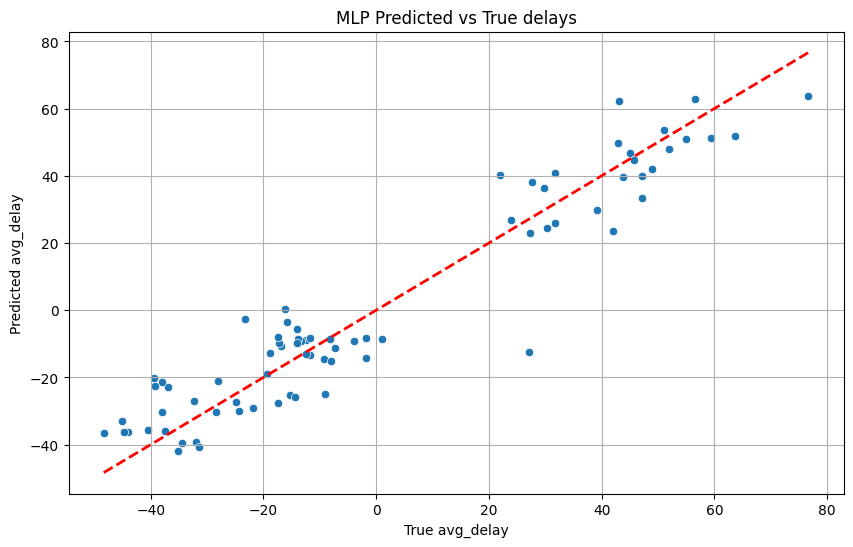

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True avg_delay")
plt.ylabel("Predicted avg_delay")
plt.title("MLP Predicted vs True delays")
plt.grid(True)
plt.show()